# Librairies

In [1]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# GridSearch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split

# Metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# tools
from joblib import dump


# Import data

In [2]:
url = 'https://raw.githubusercontent.com/remijul/dataset/master/Airline%20Passenger%20Satisfaction.csv'
df = pd.read_csv(url, sep=';')

df.head()

,id,Satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,11112,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,110278,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,103199,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,47462,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,120011,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,...,4,2,2,0,2,4,2,5,0,0.0


# Preprocessing

In [3]:
df.dropna(inplace = True) 
df.shape

(129487, 24)

In [4]:
# column transformer

num_cols = ['Age', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient',
                               'Food and drink','Gate location', 'Inflight wifi service', 'Inflight entertainment', 
                               'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 
                               'Baggage handling', 'Checkin service']
cat_cols = ['Gender', 'Customer Type','Type of Travel','Class']


cols_trans = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Model

In [5]:
# setup train test data

X = df.drop(columns='Satisfaction', axis=1)
y = df['Satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Models and parameter grids for grid search

models = [
    ('lr', LogisticRegression(), {'model__C': [0.1, 1, 10]}),
    ('ad', AdaBoostClassifier(), {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1]}),
    ('rf', RandomForestClassifier(), {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None], 'model__min_samples_split': [2, 5]})
]

##### Here is the accuracy for teseting 3 models

In [7]:
# Create pipeline and fit the model

for model_name, model, param_grid in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', cols_trans),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Validation accuracy for {model_name}: {accuracy:.4f}")

Validation accuracy for lr: 0.8351
Validation accuracy for ad: 0.8980
Validation accuracy for rf: 0.9557


In [8]:
# with display='diagram'

set_config(display='diagram')

display(pipeline)
set_config(display='text')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel', 'Class']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Flight Distance',
                                                   'Seat comfort',
                                                   'Departure/Arrival time '
                                                   'convenient',
                                                   'Food and drink',
                                                   'Gate location',
                                                   'Inflight wifi service',
                                                   'Inflight entertainment',
                                                   'Online support',
                                                   'Ease of Online booking',
                                                   'On-board service',
                                                   'Leg room service',
                                                   'Baggage handling',
                                                   'Checkin service'])])),
                ('model', RandomForestClassifier())])

##### I have a problem here, I don't understand why pipeline only shows RandomForest, but not other 2 models

## GridSearchCV

In [9]:
# Perform grid search for each model

for model_name, model, param_grid in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', cols_trans),
        ('model', model)
    ])

    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Train accuracy for {model_name}: {grid.best_score_:.4f}")
    print(f"Test accuracy for {model_name}: {grid.score(X_test, y_test):.4f}")

Best parameters for lr: {'model__C': 10}
Train accuracy for lr: 0.8351
Test accuracy for lr: 0.8352
Best parameters for ad: {'model__learning_rate': 1, 'model__n_estimators': 200}
Train accuracy for ad: 0.9005
Test accuracy for ad: 0.9001
Best parameters for rf: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Train accuracy for rf: 0.9525
Test accuracy for rf: 0.9553


In [10]:
# Fit the model on the training data with the best hyperparameters Predict the target values for the testing data

for model_name, model, param_grid in models:
    
    best_model = grid.best_estimator_
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy: ", accuracy)

    # classification report
    report = classification_report(y_test, y_pred)
    print(f"{model_name} classification report:\n", report)

lr accuracy:  0.9562514479882617
lr classification report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.96      0.95     11821
              satisfied       0.97      0.95      0.96     14077

               accuracy                           0.96     25898
              macro avg       0.96      0.96      0.96     25898
           weighted avg       0.96      0.96      0.96     25898

ad accuracy:  0.955942543825778
ad classification report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.96      0.95     11821
              satisfied       0.96      0.95      0.96     14077

               accuracy                           0.96     25898
              macro avg       0.96      0.96      0.96     25898
           weighted avg       0.96      0.96      0.96     25898

rf accuracy:  0.9562900610085721
rf classification report:
                          precision 

In [11]:
# To show the confusion Matrix

def showConfusionMatrix(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

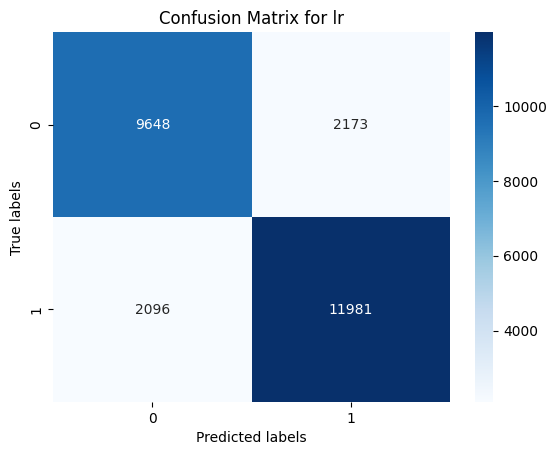

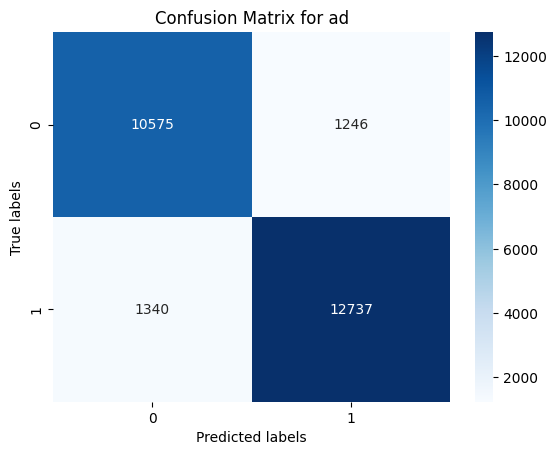

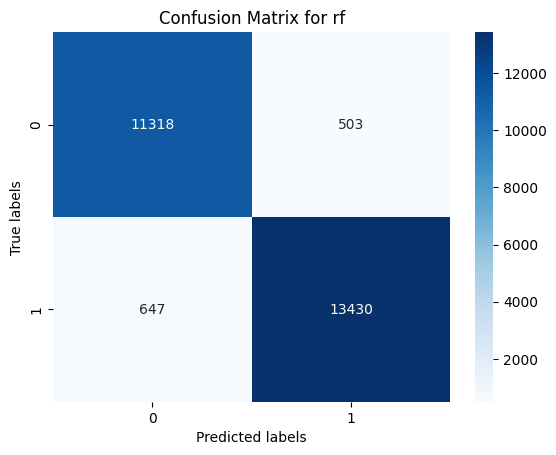

In [12]:
for model_name, model, param_grid in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', cols_trans),
        ('model', model)
    ])

    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    showConfusionMatrix(grid.best_estimator_, X_test, y_test, model_name)


    ## Here I have a problem, because I have to re-run Gridsearch, so it would be better to do a function before for it
    # and here just recall the function, but I'm a bit too bad for it

##### Apparently, even after grid search, model Random Forest is better

## Save this model

In [13]:
# Save the model to a file

dump(best_model, 'best_model_rf.joblib')

['best_model_rf.joblib']

## Caculate the feature importance for model RandomFrorest

In [14]:
best_model = grid.best_estimator_
rf_model = best_model.named_steps['model']

In [15]:
# take the importance and features from model, pipeline doesn't have contributed on 'feature_names_in_'

importances = rf_model.feature_importances_

preprocessor = best_model.named_steps['preprocessor']
cat_transformer = preprocessor.named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out(cat_cols)
feature_names = list(cat_feature_names) + num_cols

feature_importances = dict(zip(feature_names, importances))

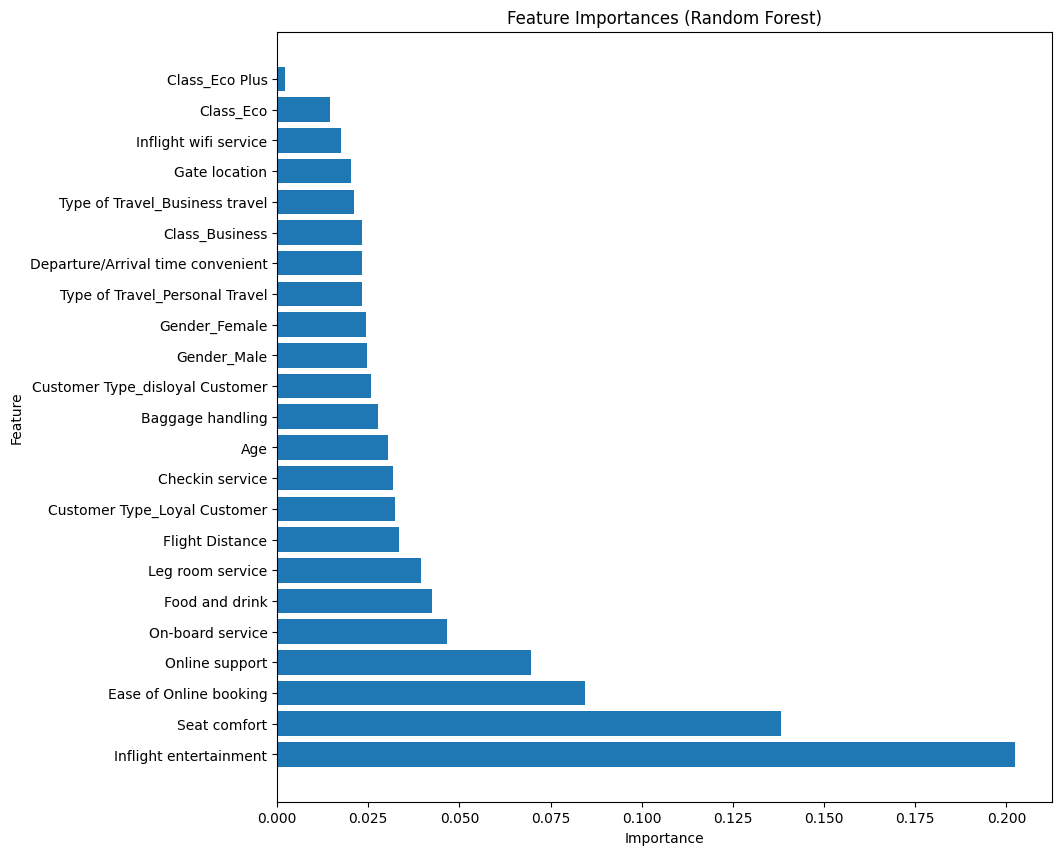

In [16]:
# order the importance values with the features
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_features = [x[0] for x in sorted_importances]
sorted_importances = [x[1] for x in sorted_importances]

plt.figure(figsize=(10, 10))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Random Forest)')
plt.show()

# Conclusions

#### Model RandomForest is better than the other two, it has 96% of accuracy and 96% F1 score
####  Based on our Ml model, "Inflight entertainment", "Seat comfort" and "Easy of on line booking" are most important factors for being "Satisfaction"

### Appweb by Streamlit: https://fengfengz93-app-airline-index-emd4ck.streamlit.app/analysis_descriptive
#### But I have a problem to upload my 'best_model_rf' to github, so when deploy the app, the page for 'model analysis' doesn't work, it works in local.